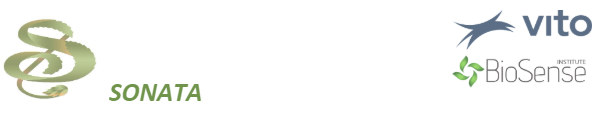
<br>
## training on VITO's hierarchical habitat mapping workflow for openEO processing platform
<br>
Copyrights, license and restrictions <br>
All code snippets, visualizations or/and workflow ideas are property of VITO. Work has been developed since 2021 and is still in development by VITO.
Showed public and private repositories are owned by VITO. <br>
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn.
Code usage is allowed with proper citation, see author list in repository.
<br>
base repository: https://github.com/ESA-WEED-project/eo_processing

### Hierarchical merge to create wall-to-wall EUNIS2021plus habitat map on Level 3

This is an example for en easy post-processing without further implementation of rules and external thematic layers. The layers are just merged by their highest probability per class model and some sanity checks are done.

created by: Dr. Marcel Buchhorn <br>
adapted by: Lori Giagnacovo

In [1]:
import pandas as pd
import rasterio
import numpy as np
import os
from pathlib import Path
import glob
import geopandas as gpd

#### Specify input

In [2]:
##### work area
# list paths to level 1,2 and 3 training data
area = 'Continental'
map_year = 2024
lut_year = 2021
# need to have an overview of all unique classes of the training points at every level
path_TP_L1 = f'/data/habitat/EU_Habitat_Models/Base_year_2024_v1/{area}/models/v1/preparation_step2/{area}_v1_TP_EUNIS{lut_year}_{map_year}_L1_all.csv'
path_TP_L2 = f'/data/habitat/EU_Habitat_Models/Base_year_2024_v1/{area}/models/v1/preparation_step2/{area}_v1_TP_EUNIS{lut_year}_{map_year}_L2_all.csv'
path_TP_L3 = f'/data/habitat/EU_Habitat_Models/Base_year_2024_v1/{area}/{area}_features_habitats_valid.csv'
# associated LUT
eunis_lut = pd.read_excel(r'/data/habitat/EU_Habitat_Models/Base_year_2024_v1/LUT_topology_EUNIS2021plus_v1.xlsx')
# list of input folders
lFolders = list(Path(f"/data/habitat/serbia/inference/{area}/{map_year}/highest_prob_maps").glob("E*N*"))

# specify L2 classes that can keep their L2 raster value (these are the ones for which actually no L3 exists)
no_exist_L3 = ['C', 'J']
# specify L1 classes that can keep their L1 raster value (these are the ones for which actually no L2 exists)
no_exist_L2 = ['C', 'J']
# Load the removed habitats from the text file into a list
with open(f'/data/habitat/EU_Habitat_Models/Base_year_2024_v1/{area}/models/v1/removed_habitats_v1.txt', 'r') as f:
    # Read the file and remove empty entries, cleaning any unwanted characters
    removed_habitats = [line.strip().strip('[]').replace("'", "").split() for line in f.readlines() if line.strip()]
    removed_habitats = [item for sublist in removed_habitats for item in sublist]  # Flatten the list
# Now, the 'removed_habitats' contains all the classes that should be skipped

#### Create output directories

In [3]:
path_root_out_L1 = os.path.normpath(f'/data/habitat/serbia/inference/{area}/{map_year}/merge_levels/Level1')
os.makedirs(path_root_out_L1, exist_ok=True)
path_root_out_L2 = os.path.normpath(f'/data/habitat/serbia/inference/{area}/{map_year}/merge_levels/Level2')
os.makedirs(path_root_out_L2, exist_ok=True)
path_root_out_L3 = os.path.normpath(f'/data/habitat/serbia/inference/{area}/{map_year}/merge_levels/Level3')
os.makedirs(path_root_out_L3, exist_ok=True)

#### Setting some functions

In [4]:
def scantree(path, fsymlinks):
    """Recursively yield DirEntry objects for given directory.
       """
    for entry in os.scandir(path):
        if "_probs" not in entry.name:
            if entry.is_dir(follow_symlinks=fsymlinks) and not entry.name.startswith('.'):
                for entry in scantree(entry.path, fsymlinks):
                    yield entry
            else:
                yield entry

In [5]:
def createDataFrame(path, pattern, fsymlinks=False):
    """Function of find all specified files (by pattern) recursively in a given
       directory and get there path into a Pandas database.
       fsymlinks=True would list also all linked files"""
    # ini empty list to hold the file info
    data = []

    # scan recursively the input folder and populate a list with data

    for entry in scantree(path, fsymlinks):
        if entry.is_file(follow_symlinks=fsymlinks) and entry.name.lower().endswith(pattern):
            data.append(os.path.normpath(entry.path))

    if len(data) != 0:
        return pd.DataFrame(data, columns=['path'])
    else:
        print(
            'scantree-dataframe creation error: There was no valid files with the chosen pattern found during the file search and no data extracted.')
        raise

In [6]:
def getLevelFiles(lFolders):
    if not lFolders:
        return None

    df_all = pd.DataFrame()

    for element in lFolders:

        # scan for files in folder to remap
        df = createDataFrame(element, '.tif')

        # split df into information - tile name and classification/probability
        df['basename'] = df['path'].apply(lambda x: os.path.basename(x))
        df['dirname'] = df['path'].apply(lambda x: os.path.basename(os.path.dirname(os.path.dirname(x))))

        if 'file_type' in df.columns:
            df.file_type.fillna(value='class', inplace=True)
        else:
            df['file_type'] = 'class'

        # Step 1: Split by "_" (underscore), since it's the main separator
        split_df = df['basename'].str.split("_", expand=True)

        # Step 2: Assign the correct parts to the new columns
        df['tile'] = split_df[0]  # Extracts "E396N312"
        df['level'] = split_df[4]  # Extracts "Level1"
        df['sub_class'] = split_df[5].str.split('.').str[0].str.split('-').str[1]

        # Append the current df to the main df_all
        df_all = pd.concat([df_all, df], ignore_index=True)

    return df_all

#### Run the code

In [7]:
# get the data
df = getLevelFiles(lFolders)
print(df.head())

                                                path  \
0  /data/habitat/serbia/inference/Continental/202...   
1  /data/habitat/serbia/inference/Continental/202...   
2  /data/habitat/serbia/inference/Continental/202...   
3  /data/habitat/serbia/inference/Continental/202...   
4  /data/habitat/serbia/inference/Continental/202...   

                                            basename            dirname  \
0  E504N244_1_classified-tile_highest-prob_Level1...  highest_prob_maps   
1  E504N244_1_classified-tile_highest-prob_Level2...  highest_prob_maps   
2  E504N244_1_classified-tile_highest-prob_Level2...  highest_prob_maps   
3  E504N244_1_classified-tile_highest-prob_Level2...  highest_prob_maps   
4  E504N244_1_classified-tile_highest-prob_Level2...  highest_prob_maps   

  file_type      tile   level sub_class  
0     class  E504N244  Level1         0  
1     class  E504N244  Level2         N  
2     class  E504N244  Level2         Q  
3     class  E504N244  Level2         R  
4 

In [8]:
# get unique tilelist
lTiles = df['tile'].unique().tolist()
# get info of how many EUNIS levels to process
lLevel = df['level'].unique().tolist()

##### First, hierarchical merge of level 2 mapped classes into the level 1 map
##### Second, hierarchical merge of level 3 mapped classes into the level 2 map

In [9]:
if not 'Level1' in lLevel:
    raise RuntimeError('Level1 data not in the provided data folders')

# now we process tile wise
for pTile in lTiles:
    print(f'* process tile: {pTile}')

    # to start we need the level 1 tile data
    try:
        path_l1 = df[(df.tile == pTile) & (df.level == 'Level1') & (df.file_type == 'class')].path.tolist()[0]
    except:
        raise RuntimeError(f'Level1 file for tile {pTile} is missing')

    # get data
    print('+ retrieve Level 1 classification data...')
    with rasterio.open(path_l1) as src:
        aData = src.read(1)
        src_profile = src.profile

    print('+ write out results level 1')
    # write out
    dst_profile = src_profile.copy()
    dst_profile.update(dtype=rasterio.int32, nodata=-1)

    file_out = os.path.join(path_root_out_L1, f'{pTile}_year{map_year}_EUNIS{lut_year}_Level1.tif')

    with rasterio.open(file_out, 'w', **dst_profile) as dst:
        dst.write(aData, 1)

    if 'Level2' in lLevel:
        print('+ imprint Level2 data into Level1 classes')
        L1_classes = pd.read_csv(path_TP_L1)
        L1_class_unique = L1_classes['habitat'].unique()
        L1_values = L1_classes.merge(eunis_lut[['eunis_code', 'raster_value']], left_on='habitat',
                                     right_on='eunis_code', how='left')
        L1_value_unique = L1_values['raster_value'].unique()
        L2_classes = pd.read_csv(path_TP_L2)
        L2_class_unique = L2_classes['habitat'].unique()
        L2_values = L2_classes.merge(eunis_lut[['eunis_code', 'raster_value']], left_on='habitat',
                                     right_on='eunis_code', how='left')
        L2_value_unique = L2_values['raster_value'].unique()

        # get list of Level2 files for this tile which can be imprinted
        # use of 'df' --> so based on for which level 2 classes a model was built!
        df_l2 = df[(df.tile == pTile) & (df.level == 'Level2') & (df.file_type == 'class')]
        df_l1_class_unique = df_l2['sub_class'].unique()
        df_l2_class_unique = [l2_class for l2_class in L2_class_unique if l2_class[0] in [l1_class[0] for l1_class in df_l1_class_unique]]

        if not df_l2.empty:
            # now we run over each of this Level 2 raster to imprint into Level1
            for row in df_l2.itertuples():
                print(f'++ retrieve & imprint data for Level 1 {row.sub_class}')
                with rasterio.open(row.path) as src:
                    aImprint = src.read(1)
                    #nodata = src.nodata
                    nodata = [0, -1]

                # get the Level 1 habitat code from the level 2 data
                lsub = np.unique(aImprint).tolist()
                lsub = [x for x in lsub if x not in nodata]
                if nodata in lsub: lsub.remove(nodata)
                if np.nan in lsub: lsub.remove(np.nan)
                lsub = [*set([int(np.floor(x / 10000) * 10000) for x in lsub])]

                if len(lsub) != 1:
                    raise RuntimeError(
                        f'level2 sub-class results should only belong to ONE level 1 class. level 2 results of file {row.path} belong to {len(lsub)} level 1 classes ({lsub}).')
                # if we have this error then check if the classified tile is containing data, probably there is 'nodata' involved in the issue.

                # now imprint the data into level 1
                aData[aData == lsub[0]] = aImprint[aData == lsub[0]]
                # free
                aImprint = None

        if len(L1_class_unique) != len(df_l1_class_unique):
            ## all other area that was not imprinted, cause no models were built, should also be assigned its level 2 class
            # first obtain these classes: one_level2_class = the classes that are in L2_class_unique but not in df_l2_class_unique
            # we make a distinction between level 1 classes with only one level 2 class or level 1 classes with multiple level 2 classes but only 1 level 2 class with more than 9 samples
            ## this can be checked by looking in the 'removed_habitats_v1.txt' file to see which classes were omitted
            L2_class_raster_values = L2_values.loc[
                L2_values['habitat'].isin(df_l2_class_unique), 'raster_value'].unique()
            unimprinted_level1_classes = [c for c in L1_class_unique if c not in df_l1_class_unique]
            # Extract classes from removed_habitats **without their last character**
            removed_habitats_L2toL1 = [cls[0] for cls in removed_habitats]
            # Ensure df_l2_class_unique is a list
            df_l1_class_unique_list = df_l1_class_unique.tolist() if isinstance(df_l1_class_unique, (
            pd.Series, np.ndarray)) else df_l1_class_unique
            # Trim last character from L3_class_unique for comparison
            L2_trimmed_counts = {}  # Dictionary to count occurrences of each trimmed L3 class
            for cls in L2_class_unique:
                trimmed = cls[0]
                L2_trimmed_counts[trimmed] = L2_trimmed_counts.get(trimmed, 0) + 1  # Count occurrences
            # Filter unimprinted_level2_classes based on conditions
            # level_1_lost_level2 --> level 1 had multiple level 2 classes but only one with more than 9 training points --> no model was built cause only one class remained
            level1_lost_level2 = [
                c for c in unimprinted_level1_classes
                if c not in (removed_habitats_L2toL1 + df_l1_class_unique_list)
                   and L2_trimmed_counts.get(c, 0) > 1]  # Must have multiple unique matches in L3_class_unique
            # we make sure that the level 1 class is translated into its only level 2 class with more than 9 training points
            unimprinted_level1_classes_reduced = [cls for cls in unimprinted_level1_classes if cls not in (no_exist_L2 + level1_lost_level2)]
            for level1_class in unimprinted_level1_classes_reduced:
                level1_value = eunis_lut.loc[eunis_lut['eunis_code'] == level1_class, 'raster_value'].iloc[0]
                # Find the corresponding Level 2 class in L2_class_unique that starts with the same letter as level1_class
                level2_class = next((l2_class for l2_class in L2_class_unique if l2_class.startswith(level1_class[0]) and l2_class not in removed_habitats), None)
                if level2_class is not None:
                    # Find the corresponding raster value for the found Level 2 class
                    level2_raster_value = L2_values.loc[L2_values['habitat'] == level2_class, 'raster_value'].iloc[0]
                    # Assign the Level 2 raster value to the unimprinted Level 1 class
                    aData[aData == level1_value] = level2_raster_value

        print('+ write out results')
        # write out
        dst_profile = src_profile.copy()
        dst_profile.update(dtype=rasterio.int32, nodata=-1)

        file_out = os.path.join(path_root_out_L2, f'{pTile}_year{map_year}_EUNIS{lut_year}_Level2.tif')

        with rasterio.open(file_out, 'w', **dst_profile) as dst:
            dst.write(aData, 1)

        if ('Level3' in lLevel) and ('Level2' in lLevel):
            print('+ imprint Level3 data into Level2 classes')
            L3_classes = gpd.read_file(path_TP_L3)
            keys_to_rename = [{'label_L3': 'habitat'}]
            for key in keys_to_rename:
                if list(key.keys())[0] in L3_classes.columns:
                    L3_classes = L3_classes.rename(columns=key)
            L3_class_unique = L3_classes['habitat'].unique()
            L3_values = L3_classes.merge(eunis_lut[['eunis_code', 'raster_value']], left_on='habitat',
                                         right_on='eunis_code', how='left')
            L3_value_unique = L3_values['raster_value'].unique()

            # get list of Level3 files for this tile which can be imprinted
            df_l3 = df[(df.tile == pTile) & (df.level == 'Level3') & (df.file_type == 'class')]
            df_l2_class_unique = df_l3['sub_class'].unique()
            df_l3_class_unique = [l3_class for l3_class in L3_class_unique if
                                  l3_class[0] in [l2_class[0] for l2_class in df_l2_class_unique]]

            if not df_l3.empty:
                # now we run over each of this Level 3 raster to imprint into Level2
                for row in df_l3.itertuples():
                    print(f'++ retrieve & imprint data for Level 2 {row.sub_class}')
                    with rasterio.open(row.path) as src:
                        aImprint = src.read(1)
                        #nodata = src.nodata
                        nodata = [0, -1]

                    # get the Level 2 habitat code from the level 3 data
                    lsub = np.unique(aImprint).tolist()
                    lsub = [x for x in lsub if x not in nodata]
                    if nodata in lsub: lsub.remove(nodata)
                    if np.nan in lsub: lsub.remove(np.nan)
                    lsub = [*set([int(np.floor(x / 100) * 100) for x in lsub])]

                    if len(lsub) != 1:
                        raise RuntimeError(
                            f'level3 sub-class results should only belong to ONE level 2 class. level 3 results of file {row.path} belong to {len(lsub)} level 2 classes ({lsub}).')

                    # now imprint the data into level 2 (if exist)
                    aData[aData == lsub[0]] = aImprint[aData == lsub[0]]
                    # free
                    aImprint = None

            if len(df_l3_class_unique) != len(L3_class_unique):
                ## all other area that was not imprinted will be assigned level 3 class
                # first obtain classes: one_level3_class = the classes that are in L3_class_unique but not in df_l3_class_unique
                # we make a distinction between level 1 classes with only one level 2 class or level 1 classes with multiple level 2 classes but only 1 level 2 class with more than 9 samples
                ## this can be check by looking in the 'removed_habitats_v1.txt' file to see which classes were omitted
                L3_class_raster_values = L3_values.loc[
                    L3_values['habitat'].isin(df_l3_class_unique), 'raster_value'].unique()
                unimprinted_level2_classes = [c for c in L2_class_unique if c not in df_l2_class_unique]
                # if not even one class could be mapped cause training data amount was below 9 for all classes, we stay at level 2
                ## check if there is a habitat not in sub_class and not in removed_habitats but still in unimprinted_level2_classes
                ## this level 2 habitat has lost all level 3 classes due to too little amount of training points and can be kept at level 2
                removed_habitats_L3toL2 = [cls[:-1] for cls in removed_habitats]
                # Ensure df_l2_class_unique is a list
                df_l2_class_unique_list = df_l2_class_unique.tolist() if isinstance(df_l2_class_unique, (pd.Series, np.ndarray)) else df_l2_class_unique
                # Trim last character from L3_class_unique for comparison
                L3_trimmed_counts = {}  # Dictionary to count occurrences of each trimmed L3 class
                for cls in L3_class_unique:
                    trimmed = cls[:-1]  # Remove last character
                    L3_trimmed_counts[trimmed] = L3_trimmed_counts.get(trimmed, 0) + 1  # Count occurrences
                # Filter unimprinted_level2_classes based on conditions
                level2_lost_level3 = [
                    c for c in unimprinted_level2_classes
                    if c not in (removed_habitats_L3toL2 + df_l2_class_unique_list)
                       and L3_trimmed_counts.get(c, 0) > 1  # Must have multiple unique matches in L3_class_unique
                ]
                unimprinted_level2_classes_reduced = [cls for cls in unimprinted_level2_classes if cls not in (no_exist_L3 + level2_lost_level3)]
                for level2_class in unimprinted_level2_classes_reduced:
                    level2_value = eunis_lut.loc[eunis_lut['eunis_code'] == level2_class, 'raster_value'].iloc[0]
                    # Find the corresponding Level 3 class in L3_class_unique that starts with the same first 2 digits as level2_class
                    level3_class = next((l3_class for l3_class in L3_class_unique if l3_class.startswith(level2_class[:2]) and not l3_class.endswith('X') and l3_class not in removed_habitats),None)
                    if level3_class is not None:
                        # Find the corresponding raster value for the found Level 2 class
                        level3_raster_value = L3_values.loc[L3_values['habitat'] == level3_class, 'raster_value'].iloc[0]
                        # Assign the Level 2 raster value to the unimprinted Level 2 class
                        aData[aData == level2_value] = level3_raster_value

            print('+ write out results')
            # write out
            dst_profile = src_profile.copy()
            dst_profile.update(dtype=rasterio.int32, nodata=-1)

            file_out = os.path.join(path_root_out_L3, f'{pTile}_year{map_year}_EUNIS{lut_year}_Level3.tif')

            with rasterio.open(file_out, 'w', **dst_profile) as dst:
                dst.write(aData, 1)

* process tile: E504N244
+ retrieve Level 1 classification data...
+ write out results level 1
+ imprint Level2 data into Level1 classes
++ retrieve & imprint data for Level 1 N
++ retrieve & imprint data for Level 1 Q
++ retrieve & imprint data for Level 1 R
++ retrieve & imprint data for Level 1 S
++ retrieve & imprint data for Level 1 T
++ retrieve & imprint data for Level 1 U
++ retrieve & imprint data for Level 1 V
+ write out results
+ imprint Level3 data into Level2 classes
++ retrieve & imprint data for Level 2 MA2
++ retrieve & imprint data for Level 2 N1
++ retrieve & imprint data for Level 2 Q2
++ retrieve & imprint data for Level 2 Q4
++ retrieve & imprint data for Level 2 Q5
++ retrieve & imprint data for Level 2 R1
++ retrieve & imprint data for Level 2 R2
++ retrieve & imprint data for Level 2 R3
++ retrieve & imprint data for Level 2 R4
++ retrieve & imprint data for Level 2 R5
++ retrieve & imprint data for Level 2 R6
++ retrieve & imprint data for Level 2 S2
++ retrie